In [93]:
# imports and loading
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1k/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
#log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

#A = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0).rename(index = {int(k) : v for k, v in k_to_iM.items()})
iM_table = pd.read_csv('../data/precise_1k/iM_table.csv', index_col = 0)
k_to_iM = {index : name for index, name in zip(iM_table.index, iM_table.name)}
M = pd.read_csv('../data/precise_1k/M.csv', index_col = 0).rename(columns = {str(k) : v for k, v in k_to_iM.items()})
A = pd.read_csv('../data/precise_1k/A.csv', index_col = 0).rename(index = k_to_iM)

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}


starve_metabs = pd.read_excel('../data/validation_data_sets/stationary_phase/metabolites_data.xlsx', index_col = 0)

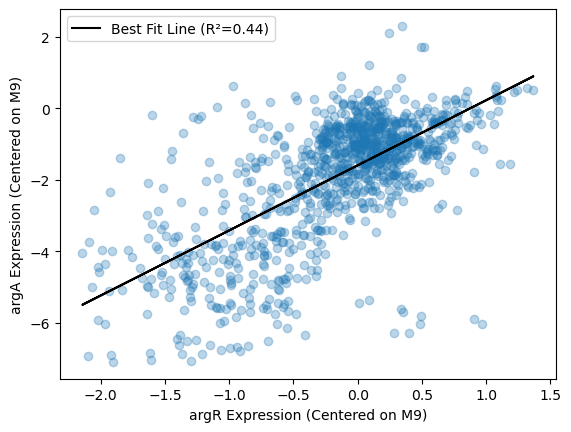

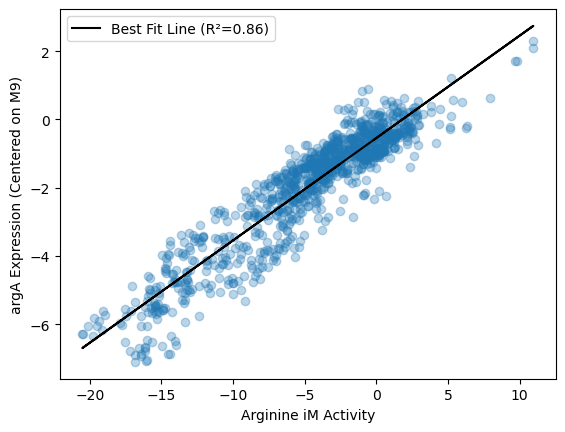

In [64]:
# plotting
plt.scatter(log_tpm_df.loc[gene_to_b['argR']], log_tpm_df.loc[gene_to_b['argA']], alpha = 0.3)

# Fit a line to the data using np.polyfit
x = log_tpm_df.loc[gene_to_b['argR']]
y = log_tpm_df.loc[gene_to_b['argA']]
coefficients = np.polyfit(x, y, 1)
poly = np.poly1d(coefficients)
# Calculate R-squared
y_pred = poly(x)
ss_total = np.sum((y - np.mean(y))**2)
ss_res = np.sum((y - y_pred)**2)
r_squared = 1 - (ss_res / ss_total)
plt.plot(x, y_pred, c = 'k', label = f'Best Fit Line (R²={r_squared:.2f})')
plt.xlabel('argR Expression (Centered on M9)')
plt.ylabel('argA Expression (Centered on M9)')
plt.legend()
plt.savefig('../figures/argR_vs_argA.pdf', transparent = True)
plt.show()

plt.scatter(A.loc['Arginine'], log_tpm_df.loc[gene_to_b['argA']], alpha = 0.3)
# Fit a line to the data using np.polyfit
x = A.loc['Arginine']
y = log_tpm_df.loc[gene_to_b['argA']]
coefficients = np.polyfit(x, y, 1)
poly = np.poly1d(coefficients)
# Calculate R-squared
y_pred = poly(x)
ss_total = np.sum((y - np.mean(y))**2)
ss_res = np.sum((y - y_pred)**2)
r_squared = 1 - (ss_res / ss_total)
plt.plot(x, y_pred, c = 'k', label = f'Best Fit Line (R²={r_squared:.2f})')
plt.xlabel('Arginine iM Activity')
plt.ylabel('argA Expression (Centered on M9)')
plt.legend()
plt.savefig('../figures/Arginine_iM_vs_argA.pdf', transparent = True)
plt.show()

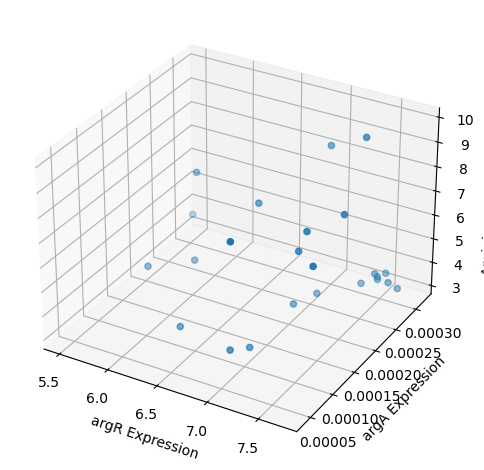

In [89]:
# 3D plotting - didn't work too well, going to try 2D with coloring
gene = 'argA'
metabolite = 'Arginine'
regulator = 'argR'

avg_starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)
# above is in (µM) , convert to M
avg_starve_metabs[avg_starve_metabs.columns[1:]] *= 1e-6

# Generate some random 3D data
np.random.seed(0)
x = starve_log_tpm.loc[gene_to_b[regulator]]
y = avg_starve_metabs.loc['Arginine'][1:]
z = starve_log_tpm.loc[gene_to_b[gene]]

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel(regulator+' Expression')
ax.set_ylabel(gene+' Expression')
ax.set_zlabel(metabolite+' Concentration')
plt.tight_layout()
plt.show()

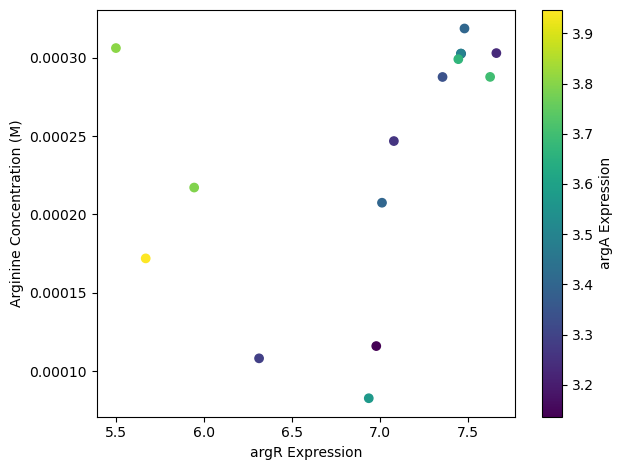

In [112]:
# 2d plot with coloring
gene = 'argA'
metabolite = 'Arginine'
regulator = 'argR'



avg_starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)
# above is in (µM) , convert to M
avg_starve_metabs[avg_starve_metabs.columns[1:]] *= 1e-6
keep_cols = [col for col in avg_starve_metabs.columns[1:] if 'growth' not in col]
keep_cols.remove('starve_series__t01_starve')
avg_starve_metabs = avg_starve_metabs[keep_cols]

# data
x = starve_log_tpm.loc[gene_to_b[regulator]][keep_cols]
y = avg_starve_metabs.loc[metabolite]
color_set = starve_log_tpm.loc[gene_to_b[gene]][keep_cols]
# Define colormap and normalization
cmap = cm.viridis  # You can choose any other colormap
normalize = plt.Normalize(vmin=min(color_set), vmax=max(color_set))

# Plotting
fig, ax = plt.subplots()  # Add this line to create a figure and axes
sc = ax.scatter(x, y, c=color_set, cmap=cmap, norm=normalize)

plt.xlabel(regulator+' Expression')
plt.ylabel(metabolite+' Concentration (M)')
# Add color bar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(gene+' Expression')
plt.tight_layout()
plt.savefig('../figures/colored_scatter.pdf', transparent = True)
plt.show()

In [104]:
starve_log_tpm.loc[gene_to_b[gene]][keep_cols]

starve_series__t01_starve    7.042089
starve_series__t02_starve    3.946312
starve_series__t03_starve    3.792167
starve_series__t04_starve    3.804096
starve_series__t05_starve    3.290533
starve_series__t06_starve    3.571390
starve_series__t07_starve    3.136768
starve_series__t08_starve    3.399291
starve_series__t09_starve    3.262803
starve_series__t10_starve    3.339298
starve_series__t11_starve    3.697777
starve_series__t12_starve    3.403327
starve_series__t14_starve    3.232916
starve_series__t16_starve    3.382075
starve_series__t17_starve    3.493216
starve_series__t18_starve    3.666108
Name: b2818, dtype: float64

In [100]:
len(y)

15